# Analyze A/B Test Results 

- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)


<a id='probability'></a>
## Part I - Probability

In [93]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [94]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [95]:
df.timestamp.max(), df.timestamp.min()

('2017-01-24 13:41:54.460509', '2017-01-02 13:42:05.378582')

In [96]:
row = df.shape[0]
row

294478

**c.** The number of unique users in the dataset.

In [97]:
unique_uid = df.user_id.nunique()
unique_uid

290584

**d.** The proportion of users converted.

In [98]:
df.query('converted == 1').shape[0]/unique_uid

0.12126269856564711

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [101]:
num_diff = df.query("(group == 'treatment' and landing_page == 'old_page')").shape[0]
num_diff

1965

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


>**no missing values**

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

In [103]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.loc[(df["group"] == 'control') == (df["landing_page"] == 'old_page')]
df2.shape

(290585, 5)

In [104]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [105]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [106]:
df2[df2['user_id'].duplicated(keep = False)== True]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [109]:
ids = df2["user_id"]
df2[ids.isin(ids[ids.duplicated()])].sort_values("user_id")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [110]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 = df2.drop_duplicates(subset='user_id', keep="first")
# Check again if the row with a duplicate user_id is deleted or not
ids2 = df2["user_id"]
df2[ids2.isin(ids2[ids2.duplicated()])].sort_values("user_id")

,user_id,timestamp,group,landing_page,converted


### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?

In [111]:
p_overall_po = df2.query('converted == 1').shape[0]/df2.shape[0]
p_overall_po

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [112]:
p_control_convert = df2.query('group=="control" and converted == 1').shape[0]/df2.query('group=="control"').shape[0]
p_control_convert

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [113]:
p_treatment_convert = df2.query('group=="treatment" and converted == 1').shape[0]/df2.query('group=="treatment"').shape[0]
p_treatment_convert

0.11880806551510564

In [114]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment_convert - p_control_convert
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [116]:
p_new_page = df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]
p_new_page

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**No, it's not.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, I can run a hypothesis test continuously as long as I observe the events. 

However, then the hard questions would be: 
- Do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider I need to make the decision just based on all the data provided.  

If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

State hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.


$$H_0: p_{new} -  p_{old}  \leq 0$$


$$H_1: p_{new} -  p_{old} > 0$$
 
$$ \alpha = 5\% $$

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [69]:
p_new = p_overall_po
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [70]:
p_old = p_overall_po
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group?

In [71]:
n_new = df2.query('landing_page == "new_page" and group =="treatment"').shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [72]:
n_old = df2.query('landing_page == "old_page" and group =="control"').shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.

In [125]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1, 0],n_new,replace = True,p = [p_new, 1-p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [126]:
p_new_2 = (new_page_converted == 1).mean()
p_new_2

0.11909022090702635

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [129]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1, 0],n_old,replace = True,p = [p_old, 1-p_old])
old_page_converted

array([1, 0, 0, ..., 0, 0, 0])

In [130]:
p_old_2 = (old_page_converted == 1).mean()
p_old_2

0.11971171716893594

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [131]:
diff_2 =p_new_2 - p_old_2
diff_2

-0.0006214962619095904


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [132]:
# Sampling distribution 
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.

Use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

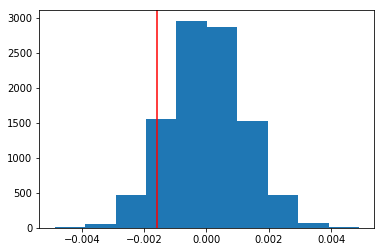

In [133]:
plt.hist(p_diffs);
plt.axvline(x= obs_diff,color ='red' )

In [134]:
p_diffs =  np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

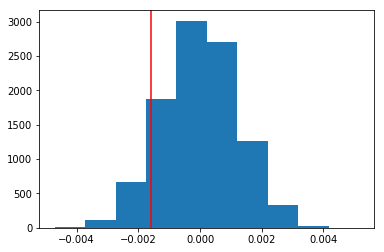

In [135]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(obs_diff, c='red')

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [136]:
obs_diff = df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
print(obs_diff)
p_diffs = np.array(p_diffs)
(p_diffs > obs_diff).mean()

-0.00157823898536


0.90339999999999998

>**We computed the p-value and it is higher than Type I error alpha, so we can't reject the H0 hypothesis<br>That means we can't conclude that the new page is better for converted customer, our experiment is less than a month so that maybe we need more time to test this hypotheses again**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [137]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('converted == 1 and landing_page == "old_page"').shape[0]

# number of conversions with the new_page
convert_new = df2.query('converted == 1 and landing_page == "new_page"').shape[0]

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"').shape[0]

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"').shape[0]

**m.** Now use `sm.stats.proportions_ztest()` to compute test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that I have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. I can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. We can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

In [138]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
count = np.array([convert_new, convert_old])
nobs = np.array([ n_new, n_old])
z_score, p_value = sm.stats.proportions_ztest(count,nobs, alternative='larger' )
print(z_score, p_value)

-1.31092419842 0.905058312759


>**We computed the p-value and it is higher than Type I error alpha, so we fail to reject the H0 hypothesis<br>That means we can't conclude that the new page is better for converted customer, our experiment is less than a month so that maybe we need more time to test this hypotheses again**

<a id='regression'></a>
### Part III - A regression approach

In this final part, the result I achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic Regression.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, I first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [85]:
df2['intercept'] = 1
df2[['drop', 'ab_page']] = pd.get_dummies(df['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,drop,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [86]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of the model below.

In [87]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-10-15 04:32 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

>**p-value = 0.1899. <br>It seems differ with the p-value in Part II
 <br>  The null hypotheses H0 is  the slope equal to 0 , alternative hypotheses H1 is slope diff than 0.
 <br>The p value in part 1 is one-side meanwhile the part III is two-side. I think it's the reason why this time the p-value is differ with last time.
 <br>With the Type I error 0.05 < p-value so we can't reject the null hypotheses which mean the slope equal to 0
 <br>We can make conlusion that the page customer see not have correlated with the converted chance, maybe because of the time is not enough for test this hypotheses.**

**f.** Considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into regression model?

>**I think we shold add type off product our website provide. Because here we can't see the correlation between page and convert rate, it is not enough, so we have to add other thing to our model. The disadvantages to adding additional terms is maybe it has correlation with ab_page call Multicollinearity, or many other problem like A linear relationship may not exist, Correlated errors, Outliers, etc**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. Need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. Call the resulting dataframe `df_merged`.

2. Does it appear that country had an impact on conversion? Consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

In [88]:
# Read the countries.csv
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [89]:
# Join with the df2 dataframe
df_merged = df2.join(df_country.set_index('user_id'), on='user_id', how = 'left')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,drop,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


In [90]:
# Create the necessary dummy variables
df_merged[['UK', 'US', 'CA']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,drop,ab_page,country,UK,US,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1


In [91]:
logit_mod_2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'UK', 'US']])
results2 = logit_mod_2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-10-15 04:33 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
UK           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
US            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

>**seems we can't reject the null because the p-value are too high, that's mean it's not have statistic significant with the converted rate**

**h. Fit your model and obtain the results**<br> 
Though I have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and conclusions (written response) based on the results. 

In [92]:
# Fit your model, and summarize the results
df_merged['page_UK'] = df_merged['ab_page']*df_merged['UK']
df_merged['page_US'] = df_merged['ab_page']*df_merged['US']
logit_mod_3 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page','UK', 'US', 'page_UK', 'page_US' ]])
results3 = logit_mod_3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-10-15 04:33 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
US           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
page_UK      -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
page_US       0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

>**Seems we can't reject the null because the p-value are too high, that's mean it's not have statistic significant with the converted rate**

<a id='conclusions'></a>
## Conclusions
<span style="color: red;">We can't conclude the new page is better base on the result of statistic. And we need more time to see the result of this testing again or add another things in our model to get the result that have statistic significance result.
The varible page, country we use is not enough for our test.</span>.

In [139]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0